# Field-dependence of parameters

The parameters in the exponential parameterization of the Hartree–Fock state depend of the amplitudes of the externally applied field

$$
\kappa =
    \kappa(F)
$$

where we, collectively, refer to all parameters gathered in the form of a matrix and also all Cartesian field amplitudes at varying angular frequencies. The reference state, $| 0 \rangle$, is that of $F=0$ for which also $\kappa = 0$.

We will here consider the case of a static, uniform, electric field. 

In calculations of the electronic energy of such a system, the external field enters explicitly in the molecular Hamiltonian but also implicitly through the wave function parameters

$$
E(\kappa, F) = 
\langle \Psi(\kappa) | \hat{H}(F) | \Psi(\kappa) \rangle
$$

At all points in the space of field amplitudes, the wave function has reached a complete orbital relaxation such that 

$$
\frac{\partial E(\kappa, F)}{\partial\kappa} = 0
$$

Based on this equation, response theory offers an analytic means to determine the wave function parameters in a region around the reference state. To first order, it is assumed that these parameters depend linearly on the field amplitudes.

We shall here investigate the accuracy of linear response (LR) theory.

In [1]:
import numpy as np
import veloxchem as vlx

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 6.


As an example, let us study the ethylene molecule.  We will assume that the electric field is aligned with one of the Cartesian molecular axes (chosen to be the $x$-axis) such that the only nonzero component of the field is $F_x^0$. This axis is further chosen as the C–C bond axis.

We expect that the largest effect of the electric field will be on the mobile $\pi$-electrons, and the $\pi$- and $\pi^*$-orbitals will therefore by of our main concern.

In [2]:
ethylene_xyz = """
6

C        0.67759997    0.00000000   0.00000000
C       -0.67759997    0.00000000   0.00000000
H        1.21655197    0.92414474   0.00000000
H        1.21655197   -0.92414474   0.00000000
H       -1.21655197   -0.92414474   0.00000000
H       -1.21655197    0.92414474   0.00000000
"""

In [3]:
molecule = vlx.Molecule.read_xyz_string(ethylene_xyz)
basis = vlx.MolecularBasis.read(molecule, "def2-svp", ostream=None)

nocc = molecule.number_of_alpha_electrons()
norb = basis.get_dimension_of_basis(molecule)
nvirt = norb - nocc

homo = nocc - 1  # Python indexing of orbitals

For the purpose of visual illustration, let us apply an *extremely* strong electric field with a field strength of 0.1 a.u., noting that this is [several orders of magnitude larger](https://kthpanor.github.io/echem/docs/spec_prop/expt_theory.html#field-strengths-and-intensities) than what is seen for intense lasers used in conventional spectroscopy.

We optimize the wave function in the presence of the field and plot the highest occupied molecular orbital (HOMO). As expected, it is seen how the electron density redistributes itself in a direction opposite of the electric field.

![Ethylene in field](../../img/spec_prop/ethylene_in_field.png)

For our continued analysis, we save the overlap matrix and the MO coefficients of the reference state.

In [4]:
scf_drv = vlx.ScfRestrictedDriver()
scf_drv.ostream.mute()

scf_results = scf_drv.compute(molecule, basis)

In [5]:
S = scf_results["S"]
C = scf_results["C_alpha"]

Next, we determine the $\kappa$-parameters with use of linear response theory, and we get a LR correction to the $\pi$-orbital that reads

$$
| \tilde{\phi}_\pi^{(1)} \rangle = 
\sum_{a}^\mathrm{virt} 
Z_{a\pi}^{x;0} | \phi_a \rangle F^0_x
$$

This follows completely analogously to the [time-dependent situation](https://kthpanor.github.io/echem/docs/spec_prop/kappa_expansion.html#illustration). As mentioned, our focus will be on the contribution to the HOMO from the $\pi^*$-orbital (or HOMO+1) in the summation.

In [22]:
lrf_drv = vlx.LinearResponseSolver()
lrf_drv.ostream.mute()

lrf_drv.frequencies = [0.0]
lrf_drv.b_components = ["x"]
lrf_results = lrf_drv.compute(molecule, basis, scf_results)

In [43]:
Z = (
    -0.5
    * (
        lrf_results["solutions"][("x", 0.0)].get_full_vector(0)
        + lrf_results["solutions"][("x", 0.0)].get_full_vector(1)
    )
    * np.sqrt(2)
)

z = Z[(nocc - 1) * nvirt]  # parameter for the pi-pi* excitation

To assess LR theory, we compare against the field-dependent HOMO of the fully relaxed Hartree–Fock state. This orbital can be expanded in terms of the reference state orbitals

$$
| \phi_\pi^F \rangle = \sum_p | \phi_p \rangle S_{p\pi}^F 
$$

where

$$
S_{p\pi}^F =
\langle \phi_{p} | \phi_\pi^F \rangle =
\sum_{\alpha,\beta}
c_{\alpha p}^* c_{\beta\pi}^F S_{\alpha\beta}
$$

Also here, we expect the most important contribution to the field-dependent $\pi$-orbital (or HOMO) to come from the unoccupied $\pi^*$-orbital (or HOMO+1) in the summation. Let us therefore determine $S_{{\pi^*}\pi}^F$.

In [44]:
field_strengths = np.linspace(-0.1, 0.1, 5)

S_field = []

for F in field_strengths:
    scf_drv.electric_field = [F, 0.0, 0.0]  # apply an electric field in the x-direction
    scf_results = scf_drv.compute(molecule, basis)
    C_field = scf_results["C_alpha"]

    S_field.append(
        -np.sign(F) * abs(np.einsum("a, b, ab ->", C[:, homo + 1], C_field[:, homo], S))
    )  # the arbitrary overall signs of orbitals is taken care of

The comparison is made visual in a plot.

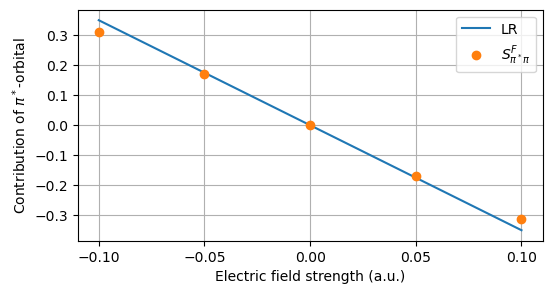

In [41]:
import matplotlib.pylab as plt

fig = plt.figure(figsize=(6, 3))

plt.plot(field_strengths, z * field_strengths, label="LR")
plt.plot(field_strengths, S_field, "o", label=r"$S_{{\pi^*}\pi}^F$")

plt.setp(plt.gca(), xticks=field_strengths)

plt.legend(frameon=True)
plt.ylabel(r"Contribution of $\pi^*$-orbital")
plt.xlabel("Electric field strength (a.u.)")

plt.grid(True)

plt.show()

The LR expansion of the Hartree–Fock wave function is seen to be accurate up to a field strength of about 0.05 a.u. whereas a significant discrepancy with respect to the field-optimized state is observed at 0.10 a.u.